# Data Wrangling

* [1. Dataset](#1)
* [2. Target variable](#2)
* [3. Features](#3)
    * [3.1 Feature names](#3.1)
    * [3.2 Feature types](#3.2)
    * [3.3 Missing values](#3.3)
    * [3.4 Unique values per feature](#3.4)
* [4. Post-cleaning data](#4)
    * [4.1 Numerical features, integers](#4.1)
    * [4.2 Numerical features, floats](#4.2)
    * [4.3 Categorical features](#4.3)
* [5. Supporting dataset with city information](#5)
* [6. Summary](#6)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

## 1. Dataset <a id='1'></a>

The data comes in two samples: *train.csv* for model building and training and *test.csv* for churn prediction. Let's read them in. Let's set the index to the *ID* column. Since the dataset is large, let's also set the *low_memory* parameter to *False* to prevent input chunking that causes mixed-type variable warnings. Finally, let's also allow automatic recognition of datetime variables, if they are present in the data.

In [2]:
df_work = pd.read_csv("./train.csv",index_col='ID',low_memory=False,parse_dates=True,infer_datetime_format=True)
df_pred = pd.read_csv("./test.csv" ,index_col='ID',low_memory=False,parse_dates=True,infer_datetime_format=True)

What are their dimesions?:

In [3]:
df_work.shape,df_pred.shape

((145231, 1933), (145232, 1932))

Both samples have about 145k rows and 1930 columns,

In [4]:
set(df_work.columns) - set(df_pred.columns)

{'target'}

and the only difference between the columns in the two datasets is the *target* column. As expected, it is present in the *work* sample that will be used for model training and testing and absent in the *pred* sample for churn predictions. Let's also print the first few indices for rows in both samples:

In [5]:
print(df_work.index[:15])
print(df_pred.index[:15])

Int64Index([2, 4, 5, 7, 8, 14, 16, 20, 21, 22, 23, 24, 25, 26, 28], dtype='int64', name='ID')
Int64Index([1, 3, 6, 9, 10, 11, 12, 13, 15, 17, 18, 19, 27, 29, 33], dtype='int64', name='ID')


They are complementary to each other and sum up to a complete list of ordered integers. This means that the two samples were randomly selected from a common dataset (as opposed to e.g. two datasets taken at different times or with other conditions). Let's inspect the target variable now.

## 2. Target variable <a id='2'></a>

Let's plot a histogram of the *target* column and calculate the number and percentage of unique entries:

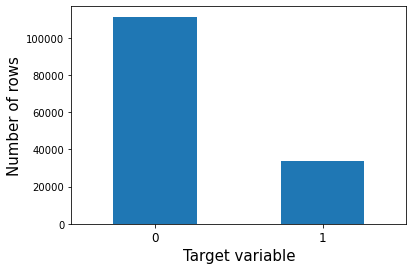

In [6]:
df_work['target'].value_counts().plot(kind='bar')

plt.ylabel('Number of rows',fontsize=15)
plt.xlabel('Target variable',fontsize=15)
plt.xticks(rotation=0,fontsize=12);

In [7]:
tv = pd.concat([df_work['target'].value_counts(),df_work['target'].value_counts(normalize=True)*100],axis=1)
tv.columns =['N. of rows', '% of total']
tv.round(1)

,N. of rows,% of total
0,111458,76.7
1,33773,23.3


The target has only two values, 0 and 1, as expected for a binary classification problem. The churn distribution is pretty asymmetric, with only about a quarter of customers (~34k entries) responding to the offer. 

The cumulative distribution of the number of positive responses as a function of data index is shown below:

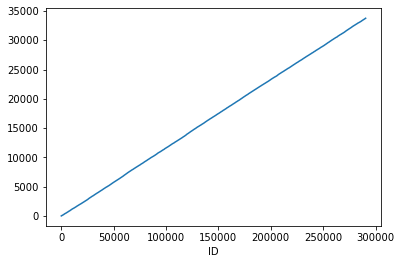

In [8]:
df_work['target'].cumsum().plot();

A linear dependence implies that the *yes* responses are uniformly distributed in the dataset. This is a useful feature that will allow us to apply the standard splitting method for the model cross-validation in later studies (index-ordered chunking, as opposed to random sampling).

In preparation for further analysis, let's separate the target variable from the rest of the *work* dataset and save it as a dataframe named *y*:

In [9]:
y = df_work['target']

df_work = df_work.drop('target', axis=1)
df_work.shape

(145231, 1932)

## 3. Features <a id='3'></a>

Now, let's inspect the features. First, we check the names of the dataset columns:

### 3.1 Feature names <a id='3.1'></a>

In [10]:
df_work.columns

Index(['VAR_0001', 'VAR_0002', 'VAR_0003', 'VAR_0004', 'VAR_0005', 'VAR_0006',
       'VAR_0007', 'VAR_0008', 'VAR_0009', 'VAR_0010',
       ...
       'VAR_1925', 'VAR_1926', 'VAR_1927', 'VAR_1928', 'VAR_1929', 'VAR_1930',
       'VAR_1931', 'VAR_1932', 'VAR_1933', 'VAR_1934'],
      dtype='object', length=1932)

All of them are anonymized and ordered from 1 to 1934. We have 1932 columns, so 2 indices seem to be missing, what are they?:

In [11]:
var_id = df_work.columns.str.replace('VAR_','').astype('int')

for i in range(1,1935):
    if i not in var_id:
        print('VAR_{}'.format(str(i).zfill(4)))

VAR_0218
VAR_0240


It's not clear why they had been removed from the dataset, but it's also irrelevant for our analysis, so let's carry on and inspect feature data types now:

### 3.2 Feature types <a id='3.2'></a>

The standard pandas *dtypes* function:

In [12]:
df_work.dtypes.value_counts()

int64      1404
float64     477
object       51
dtype: int64

gives approximately 73% integers, 25% floats, and 3% *object* types. But this classification might not be very representative if missing values (NaNs) are present in the columns. This is because pandas treats NaN variables as floats and concequently classifies integer columns with NaNs as floats. It also classifies string or bool columns with NaNs as *object* types. A more informative classification can be done by means of the *convert_dtypes()* function, which ignores missing numbers when inferring data types:

In [13]:
df_work.convert_dtypes().dtypes.value_counts()

Int64      1871
string       38
boolean      13
float64      10
dtype: int64

It's clear now that our dataset is basically dominated by integer columns (97%) with a very small admixture of floats, bools and strings. 

Missing values have quite an impact on the column type assignement, so let's investigate them now.

### 3.3 Missing values <a id='3.3'></a>

Let's count the total number of missing values per column and display it as a function of a column id, for the *work* sample:

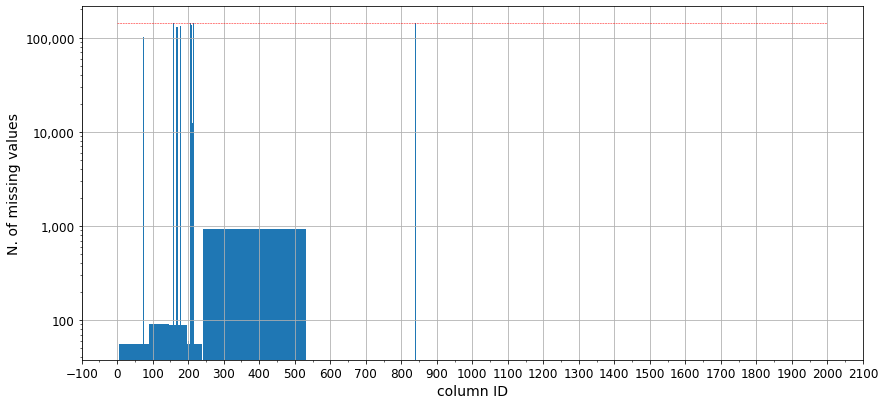

In [14]:
var_id = df_work.columns.str.replace('VAR_','').astype('int')
nmiss = df_work.isna().sum()

fig, ax = plt.subplots(figsize=(14,6.5))

ax.hist(var_id,weights=nmiss,range=(0,2000),bins=2000)

ax.set_yscale('log')

ax.grid()

ax.set_xlabel("column ID",fontsize=14)
ax.set_ylabel("N. of missing values",fontsize=14)

ax.tick_params(axis="x", labelsize=12) 
ax.tick_params(axis="y", labelsize=12) 

ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.hlines(df_work.shape[0],0,2000,linewidth=0.5,linestyle='--',color='r');

Note a log scale on the y axis. What's interesting? Three observations:

1) missing values are present only in the first 530 columns, plus one additional column around 840,<br>
2) there are several columns with a very high number of missing values, approaching the total number of rows in the dataset, shown as a red line,<br>
3) there are 3 or 4 blocks of adjacent columns with the same number of missing values. Their fraction is tiny, though - about 50, 100, and 1000 rows out of the total of 145k rows, so always below 1%.

__Ad 1:__ The fact that the fields with explicitly marked missing values (*NA* in the csv input file) are present only in the first quarter of the dataset doesn't mean that missing values are not present in the remaining part of the sample. They might be encoded as integers, for example as a commonly used $-1$ digit or as very small or very large numbers, e.g. $1-10^n$ or $10^n-1$ with $n=1,2\dots$. We will explore this matter later when dealing with integer-type features.

__Ad 2:__ what are the names of the columns with a large number of missing values, and what fraction of rows is missing for them?:

In [15]:
nmiss_per_col = df_work.isna().sum()

thres = df_work.shape[0]/2

print(nmiss_per_col[nmiss_per_col>thres].count(),'columns with % missing:')
(nmiss_per_col[nmiss_per_col>thres]/df_work.shape[0]*100).round(2).astype('str') + ' %'

24 columns with % missing:


VAR_0073    69.63 %
VAR_0074    69.63 %
VAR_0156    95.96 %
VAR_0157    99.37 %
VAR_0158    98.56 %
VAR_0159    95.96 %
VAR_0166     90.2 %
VAR_0167    98.23 %
VAR_0168    92.62 %
VAR_0169     90.2 %
VAR_0176    87.93 %
VAR_0177    97.69 %
VAR_0178    91.69 %
VAR_0179    87.93 %
VAR_0205    98.45 %
VAR_0206     98.4 %
VAR_0207    100.0 %
VAR_0208     86.6 %
VAR_0209    93.54 %
VAR_0210     86.6 %
VAR_0211     86.6 %
VAR_0213    100.0 %
VAR_0214    99.99 %
VAR_0840    100.0 %
dtype: object

Ups, 3 columns are totally empty, with 100% missing values. They include column 840, the right-most outlier in the plot above. These columns need to be removed from the dataset and we will do it in the next section of this notebook. The other columns will have to be investigated in more detail before deciding how to treat them.

 __Ad 3:__ let's inspect blocks with the same fraction of missing rows. Let's select them by looking at the 5 most frequent missing-row numbers, and let's check in how many columns they appear:

In [16]:
nmiss_hist = nmiss_per_col.value_counts().head()
nmiss_hist

0      1407
918     286
56      115
91       56
89       38
dtype: int64

1407 columns have no missing numbers, then there are 4 groups with 918, 56, 91 and 89 missing numbers each. What range of columns do they span?:

In [17]:
n_col_first = {n:df_work.columns[df_work.isna().sum() == n][0] for n in sorted(nmiss_hist.index[1:])}
n_col_last  = {n:df_work.columns[df_work.isna().sum() == n][-1] for n in sorted(nmiss_hist.index[1:])}

for k in n_col_first.keys():
    
    print(n_col_first[k],'-',n_col_last[k],'range for the block with',k,'NaNs')

VAR_0006 - VAR_0241 range for the block with 56 NaNs
VAR_0146 - VAR_0195 range for the block with 89 NaNs
VAR_0090 - VAR_0145 range for the block with 91 NaNs
VAR_0242 - VAR_0530 range for the block with 918 NaNs


As the final check, let's also investigate what's the relation between these blocks. Are they separated or have common parts? To answer this question let's count and plot missing values again, this time only in the rows corresponding to a particular block:

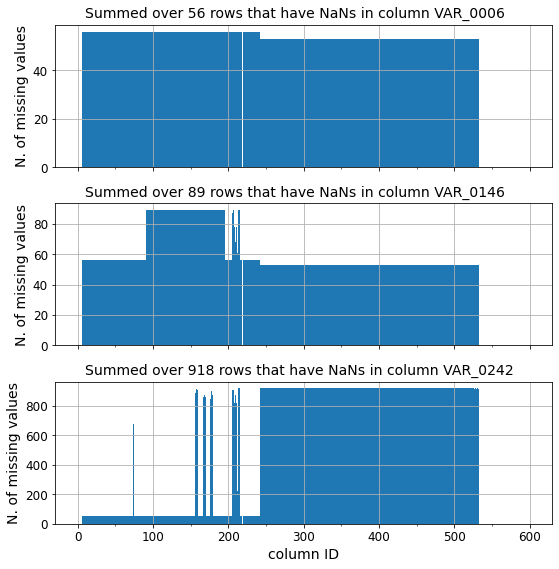

In [18]:
fig, ax = plt.subplots(3,1,figsize=(8,8),sharex=True)

rmax = 600
nm = [56,89,918]

ax[0].hist(var_id,weights=df_work[df_work[n_col_first[nm[0]]].isna()].isna().sum(),range=(0,rmax),bins=rmax)
ax[1].hist(var_id,weights=df_work[df_work[n_col_first[nm[1]]].isna()].isna().sum(),range=(0,rmax),bins=rmax)
ax[2].hist(var_id,weights=df_work[df_work[n_col_first[nm[2]]].isna()].isna().sum(),range=(0,rmax),bins=rmax)

ax[2].set_xlabel("column ID",fontsize=14)

for i,a in enumerate(ax):
    
    a.grid()
    
    a.set_ylabel("N. of missing values",fontsize=14)
    
    a.tick_params(axis="x", labelsize=12) 
    a.tick_params(axis="y", labelsize=12) 

    a.xaxis.set_major_locator(ticker.MultipleLocator(100))
    a.xaxis.set_minor_locator(ticker.MultipleLocator(50))
    a.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    a.text(0.06, 1.05,'Summed over {} rows that have NaNs in column {}'.format(nm[i],n_col_first[nm[i]]), transform=a.transAxes,fontsize=14)
    
plt.tight_layout()

In the top plot, we select rows that have NaNs in the 56 NaNs block (strictly speaking, in the first column of that block, column 6) and observe that NaNs are also present in the columns for other blocks. A small drop around column 242 corresponds to a few non-empty rows in the 918 block. For the rows corresponding to the 89 NaNs block (middle plot) the 91 block is selected as well, but no excess above the 56 NaNs block is observed in the 918 NaNs range. Inversely, if the rows corresponding to the 918 NaNs block are selected (bottom plot), no excess is observed in the range of the 89 and 91 NaNs blocks. This means that the 918 NaNs and 89/91 NaNs blocks are separated, but both have rows common with the 56 NaNs block. And that's about it. This study could potentially have an impact on our analysis if the number of missing values were high. But since the missing fraction is below 1% we will stop here and move to the next step.

What's the next step? It's time to inspect feature content. It impractical to plot distributions of more than 1930 variables, so we will use some aggregated information instead. We will start with plotting the number of unique values for each of the features, then inspect low-multiplicity features to do some initial data cleaning. Hopefully, with a few printouts, we will also be able to gain insight into what kind of anonymized dataset we are dealing with.

### 3.4 Unique values per feature <a id='3.4'></a>

The histogram below shows the distribution of feature unique values:

In [19]:
s_unique = df_work.nunique(dropna=False)
n_unique = s_unique.values

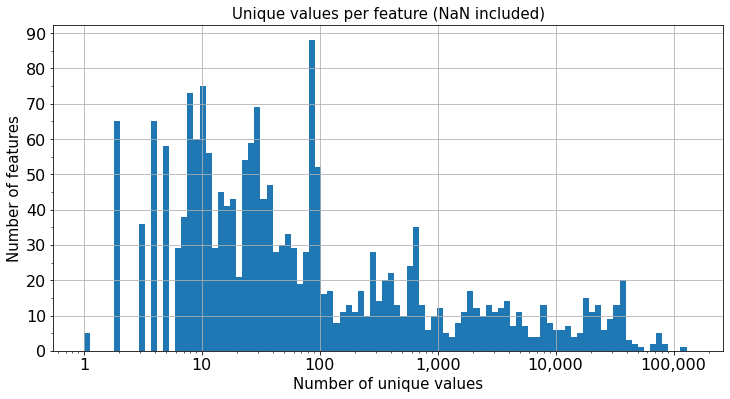

In [20]:
plt.figure(figsize=(12,6))

hist, bins= np.histogram(n_unique, bins=100)
logbins = np.logspace(np.log10(1),np.log10(bins[-1]),len(bins))

plt.hist(n_unique, bins=logbins)

plt.grid()

plt.xscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title("Unique values per feature (NaN included)",fontsize=15)
plt.xlabel("Number of unique values",fontsize=15)
plt.ylabel("Number of features",fontsize=15)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(5))

The spectrum is very wide, from 5 columns with just one value, to a column with more than 100 thousand values. Let's see what's in those 5 columns that have only one unique value:

In [21]:
cols_1 = s_unique[s_unique == 1].index

for col in cols_1:
    print(col,':',df_work[col].unique())

VAR_0207 : [nan]
VAR_0213 : [nan]
VAR_0840 : [nan]
VAR_0847 : [1]
VAR_1428 : [0]


These columns have no variance, therefore they will have no impact on the separation of the customer response. Let's remove them from the dataset:

In [22]:
df_work = df_work.drop(cols_1,axis=1)
df_pred = df_pred.drop(cols_1,axis=1)

df_work.shape,df_pred.shape

((145231, 1927), (145232, 1927))

Now, let's also print out the content of the columns with 2, 3, 4 and 5 unique entries:

In [23]:
cols_2 = s_unique[s_unique == 2].index

for col in cols_2:
    print(col,':',df_work[col].unique())

VAR_0008 : [False nan]
VAR_0009 : [False nan]
VAR_0010 : [False nan]
VAR_0011 : [False nan]
VAR_0012 : [False nan]
VAR_0018 : [ 0. nan]
VAR_0019 : [ 0. nan]
VAR_0020 : [ 0. nan]
VAR_0021 : [ 0. nan]
VAR_0022 : [ 0. nan]
VAR_0023 : [ 0. nan]
VAR_0024 : [ 0. nan]
VAR_0025 : [ 0. nan]
VAR_0026 : [ 0. nan]
VAR_0027 : [ 0. nan]
VAR_0028 : [ 0. nan]
VAR_0029 : [ 0. nan]
VAR_0030 : [ 0. nan]
VAR_0031 : [ 0. nan]
VAR_0032 : [ 0. nan]
VAR_0038 : [ 0. nan]
VAR_0039 : [ 0. nan]
VAR_0040 : [ 0. nan]
VAR_0041 : [ 0. nan]
VAR_0042 : [ 0. nan]
VAR_0043 : [False nan]
VAR_0044 : ['[]' nan]
VAR_0188 : [ 0. nan]
VAR_0189 : [ 0. nan]
VAR_0190 : [ 0. nan]
VAR_0196 : [False nan]
VAR_0197 : [201.  nan]
VAR_0199 : [ 0. nan]
VAR_0202 : ['BatchInquiry' nan]
VAR_0203 : [ 1. nan]
VAR_0215 : [101.  nan]
VAR_0216 : ['DS' nan]
VAR_0221 : [ 0. nan]
VAR_0222 : ['C6' nan]
VAR_0223 : [2471.   nan]
VAR_0229 : [False nan]
VAR_0239 : [False nan]
VAR_0246 : [-1. nan]
VAR_0394 : [ 0. nan]
VAR_0438 : [ 0. nan]
VAR_0446 : [ 0.

In [24]:
cols_3 = s_unique[s_unique == 3].index

for col in cols_3:
    print(col,':',df_work[col].unique())

VAR_0001 : ['H' 'R' 'Q']
VAR_0098 : [ 0.  1. nan]
VAR_0106 : [ 0. nan  1.]
VAR_0114 : [ 0.  1. nan]
VAR_0130 : [ 0.  1. nan]
VAR_0138 : [ 0.  1. nan]
VAR_0180 : [ 0.  1. nan]
VAR_0181 : [ 0.  1. nan]
VAR_0182 : [ 0.  1. nan]
VAR_0191 : [ 0. nan  1.]
VAR_0226 : [False True nan]
VAR_0230 : [False True nan]
VAR_0232 : [True False nan]
VAR_0236 : [True False nan]
VAR_0244 : [ 1. nan  0.]
VAR_0247 : [ 0. nan  1.]
VAR_0344 : [ 0.  1. nan]
VAR_0362 : [ 1.  0. nan]
VAR_0383 : [ 1.  0. nan]
VAR_0384 : [ 0.  1. nan]
VAR_0392 : [ 0. nan  1.]
VAR_0395 : [ 0. nan  1.]
VAR_0411 : [ 0. nan  1.]
VAR_0459 : [ 0. nan  1.]
VAR_0466 : ['-1' 'I' nan]
VAR_0468 : [ 0. nan  1.]
VAR_0490 : [ 1.  0. nan]
VAR_0502 : [ 0. nan  1.]
VAR_0503 : [ 0.  1. nan]
VAR_0504 : [ 0.  1. nan]
VAR_0505 : [ 0.  1. nan]
VAR_0526 : [ 0. nan  1.]
VAR_0529 : [ 0. nan  1.]
VAR_0923 : [0 1 9]
VAR_1175 : [ 0  1 99]
VAR_1176 : [ 0  1 99]


In [25]:
cols_4 = s_unique[s_unique == 4].index

for col in cols_4:
    print(col,':',df_work[col].unique())

VAR_0005 : ['C' 'B' 'N' 'S']
VAR_0090 : [ 0.  1.  2. nan]
VAR_0091 : [ 0.  1.  2. nan]
VAR_0099 : [ 0.  1. nan  2.]
VAR_0107 : [ 0.  1. nan  2.]
VAR_0115 : [ 0.  1. nan  2.]
VAR_0122 : [ 1.  0. nan  2.]
VAR_0139 : [ 0.  1. nan  2.]
VAR_0183 : [ 0.  1. nan  2.]
VAR_0192 : [ 0. nan  1.  2.]
VAR_0248 : [ 0. nan  1. -1.]
VAR_0252 : [ 1.  0. nan -1.]
VAR_0271 : [ 0.  1. nan -1.]
VAR_0275 : [ 0. nan  1. -1.]
VAR_0276 : [ 0.  1. nan -1.]
VAR_0277 : [ 0.  1. nan -1.]
VAR_0281 : [ 2. -1.  1. nan]
VAR_0285 : [ 1. -1.  0. nan]
VAR_0286 : [ 0. -1.  1. nan]
VAR_0287 : [ 0. -1.  1. nan]
VAR_0291 : [ 0.  1. -1. nan]
VAR_0292 : [ 1.  0. nan -1.]
VAR_0306 : [ 1.  0. -1. nan]
VAR_0307 : [ 0.  1. -1. nan]
VAR_0308 : [ 0.  1. -1. nan]
VAR_0312 : [ 1.  0. -1. nan]
VAR_0326 : [ 0.  1. -1. nan]
VAR_0327 : [ 0.  1. -1. nan]
VAR_0328 : [ 0.  1. -1. nan]
VAR_0339 : [ 0. -1.  1. nan]
VAR_0345 : [-1.  0.  1. nan]
VAR_0346 : [-1.  1.  0. nan]
VAR_0347 : [-1.  0. nan  1.]
VAR_0348 : [-1.  0. nan  1.]
VAR_0377 : [ 0

In [26]:
cols_5 = s_unique[s_unique == 5].index

for col in cols_5:
    print(col,':',df_work[col].unique())

VAR_0092 : [ 0.  1.  2. nan  3.]
VAR_0108 : [ 0.  1.  2. nan  3.]
VAR_0116 : [ 0.  1. nan  2.  4.]
VAR_0123 : [ 1.  0.  2. nan  3.]
VAR_0124 : [ 1.  0.  2.  3. nan]
VAR_0131 : [ 0.  1.  2. nan  3.]
VAR_0150 : [ 0.  1.  2. nan  3.]
VAR_0153 : [ 0.  1.  2. nan  3.]
VAR_0163 : [ 0.  1.  2.  3. nan]
VAR_0173 : [ 0.  1.  2.  3. nan]
VAR_0193 : [ 0. nan  1.  3.  2.]
VAR_0194 : [ 0.  1. nan  3.  2.]
VAR_0249 : [ 3. nan  1.  0.  2.]
VAR_0250 : [ 2. nan -1.  0.  1.]
VAR_0251 : [ 2.  0.  1. nan -1.]
VAR_0259 : [ 0.  1. nan  2.  3.]
VAR_0264 : [ 0. nan  1.  2.  3.]
VAR_0265 : [ 0.  1. nan  2.  3.]
VAR_0290 : [ 3. -1.  2.  1. nan]
VAR_0311 : [ 3. -1.  2.  1. nan]
VAR_0352 : ['O' 'R' 'U' '-1' nan]
VAR_0353 : ['U' 'R' 'O' '-1' nan]
VAR_0354 : ['O' 'R' '-1' 'U' nan]
VAR_0371 : [ 0. nan  1.  2.  3.]
VAR_0372 : [ 0. nan  1.  2.  3.]
VAR_0378 : [ 0. nan  1.  5.  2.]
VAR_0387 : [ 0. nan  1.  2.  4.]
VAR_0420 : [ 0. nan  1.  2.  3.]
VAR_0467 : ['-1' 'Discharged' 'Dismissed' nan 'Discharge NA']
VAR_0472 : 

What can we say about the data? A few things:

1) majority of the two-value columns contain a NaN and another value appearing as a number, string or a bool. To clean up the dataset, let's preserve the NaNs but convert all other values to 1:

In [27]:
n2_nan = df_work[cols_2].isnull().sum()

cols_n2_nan = n2_nan[n2_nan>0].index

for col in cols_n2_nan:
    df_work[col] = df_work[col].where(lambda x: x.isna(),1.)
    df_pred[col] = df_pred[col].where(lambda x: x.isna(),1.)

#Series.where(cond, other=nan, inplace=False)
#if cond is True, keep the original value, otherwise (False) replace with corresponding value from 'other'.
#if no 'other' given, replace with nan; where(isna) will give the entire column filled with nan :)

There are also 4 columns with the values of -99999 and 0. To unify the notation with all the other columns, let's replace -999999 by 1:

In [28]:
for col in ['VAR_0732','VAR_0733','VAR_0736','VAR_0737','VAR_0739']:

    df_work[col] = df_work[col].replace(-99999,1)
    df_pred[col] = df_pred[col].replace(-99999,1)

OK, how do these columns look now? Let's print them again, this time showing also the number of missing values that they contain:

In [29]:
for col in cols_2:
    print(col,df_work[col].unique(),df_work[col].isna().sum())

VAR_0008 [1.0 nan] 56
VAR_0009 [1.0 nan] 56
VAR_0010 [1.0 nan] 56
VAR_0011 [1.0 nan] 56
VAR_0012 [1.0 nan] 56
VAR_0018 [ 1. nan] 56
VAR_0019 [ 1. nan] 56
VAR_0020 [ 1. nan] 56
VAR_0021 [ 1. nan] 56
VAR_0022 [ 1. nan] 56
VAR_0023 [ 1. nan] 56
VAR_0024 [ 1. nan] 56
VAR_0025 [ 1. nan] 56
VAR_0026 [ 1. nan] 56
VAR_0027 [ 1. nan] 56
VAR_0028 [ 1. nan] 56
VAR_0029 [ 1. nan] 56
VAR_0030 [ 1. nan] 56
VAR_0031 [ 1. nan] 56
VAR_0032 [ 1. nan] 56
VAR_0038 [ 1. nan] 56
VAR_0039 [ 1. nan] 56
VAR_0040 [ 1. nan] 56
VAR_0041 [ 1. nan] 56
VAR_0042 [ 1. nan] 56
VAR_0043 [1.0 nan] 56
VAR_0044 [1.0 nan] 56
VAR_0188 [ 1. nan] 89
VAR_0189 [ 1. nan] 89
VAR_0190 [ 1. nan] 89
VAR_0196 [1.0 nan] 56
VAR_0197 [ 1. nan] 56
VAR_0199 [ 1. nan] 56
VAR_0202 [1.0 nan] 56
VAR_0203 [ 1. nan] 56
VAR_0215 [ 1. nan] 56
VAR_0216 [1.0 nan] 56
VAR_0221 [ 1. nan] 56
VAR_0222 [1.0 nan] 56
VAR_0223 [ 1. nan] 56
VAR_0229 [1.0 nan] 56
VAR_0239 [1.0 nan] 56
VAR_0246 [ 1. nan] 918
VAR_0394 [ 1. nan] 918
VAR_0438 [ 1. nan] 918
VAR_044

They look the same within each group of NaNs. Can there be duplicates? 

Let's write and run a function that compares each pair of columns row-wise and creates duplicate lists. The output of the function is a dictionary whose keys correspond to the first column in each of lists (to remain in the dataset) while values contain the duplicate columns (to be removed from the dataset):

In [30]:
def find_duplicate_cols(df,cols):
    
    dups = {}
    
    cols_removed = []

    for i,c1 in enumerate(cols):
    
        if c1 in cols_removed:
            continue
    
        for c2 in cols[i+1:]: 
        
            if c2 in cols_removed:
                continue
                
            if (df[c1].astype('str') == df[c2].astype('str')).sum() == df.shape[0]:

                if c1 not in dups.keys():
                    dups[c1] = []
                        
                dups[c1].append(c2)
                cols_removed.append(c2)
                
    return dups

In [31]:
dups = find_duplicate_cols(df_work,cols_2)

for key in dups.keys():
    print(key,':',dups[key])

VAR_0008 : ['VAR_0009', 'VAR_0010', 'VAR_0011', 'VAR_0012', 'VAR_0018', 'VAR_0019', 'VAR_0020', 'VAR_0021', 'VAR_0022', 'VAR_0023', 'VAR_0024', 'VAR_0025', 'VAR_0026', 'VAR_0027', 'VAR_0028', 'VAR_0029', 'VAR_0030', 'VAR_0031', 'VAR_0032', 'VAR_0038', 'VAR_0039', 'VAR_0040', 'VAR_0041', 'VAR_0042', 'VAR_0043', 'VAR_0044', 'VAR_0196', 'VAR_0197', 'VAR_0199', 'VAR_0202', 'VAR_0203', 'VAR_0215', 'VAR_0216', 'VAR_0221', 'VAR_0222', 'VAR_0223', 'VAR_0229', 'VAR_0239']
VAR_0188 : ['VAR_0189', 'VAR_0190']
VAR_0246 : ['VAR_0394', 'VAR_0438', 'VAR_0446', 'VAR_0527', 'VAR_0528', 'VAR_0530']


So many duplicates! All the columns in each group of different non-zero NaNs are repeated. Let's remove the duplicates from both datasets now:

In [32]:
for key in dups.keys():
    
    df_work = df_work.drop(dups[key],axis=1)
    df_pred = df_pred.drop(dups[key],axis=1)

df_work.shape,df_pred.shape       

((145231, 1881), (145232, 1881))

Great! By doing so we managed to reduce the number of features from 1927 to 1881.

2) Among columns with 3 unique values 4 of them contain bool variables ( column ID = 226, 230, 232, and 236). Let's check if there are other bools in our dataset.

In [33]:
n_False =(df_work.select_dtypes(include='object').astype('str')  == 'False').sum()
n_False[n_False>0]

VAR_0226    144703
VAR_0230    145004
VAR_0232     63057
VAR_0236       326
dtype: int64

In [34]:
n_True =(df_work.select_dtypes(include='object').astype('str') == 'True').sum()
n_True[n_True>0]

VAR_0226       472
VAR_0230       171
VAR_0232     82118
VAR_0236    144849
dtype: int64

Nope, apart from the 4 columns mentioned above, there are no more logical features in the dataset. 

Let's get rid of bools in these columns by replacing *False*(*True*) by 0(1):

In [35]:
for col in n_False[n_False>0].index:
    df_work[col] = df_work[col].replace(False,0)
    df_pred[col] = df_pred[col].replace(False,0)
    
for col in n_True[n_True>0].index:
    df_work[col] = df_work[col].replace(True,1)
    df_pred[col] = df_pred[col].replace(True,1)

3) Are there any duplicates in the columns with 3, 4 and 5 unique values?:

In [36]:
dups = find_duplicate_cols(df_work,cols_3)

for key in dups.keys():
    print(key,':',dups[key])


VAR_0180 : ['VAR_0181', 'VAR_0182']
VAR_0526 : ['VAR_0529']


In [37]:
dups = find_duplicate_cols(df_work,cols_4)

for key in dups.keys():
    print(key,':',dups[key])

In [38]:
dups = find_duplicate_cols(df_work,cols_5)

for key in dups.keys():
    print(key,':',dups[key])

There are 2 groups of duplicates in the columns with 3 unique values, and no duplicates in the columns with 4 or 5 values. 

Let's remove the repeated columns:

In [39]:
for key in dups.keys():
    
    df_work = df_work.drop(dups[key],axis=1)
    df_pred = df_pred.drop(dups[key],axis=1)

df_work.shape,df_pred.shape   

((145231, 1881), (145232, 1881))

4) Generally, as the multiplicity of unique values increases the column content become more regular. While columns with 2 and 3 entries required some extra work, columns with 4 and 5 entries are pretty clean. One noticeable issue in those columns is the presence of outstanding numbers, such -1, -9999, 99, 999. As mentioned earlier, these might be numerically-encoded missing values. Another issue is the presence of groups of large outstanding values. For example, for features with 5 uniue values, a few columns contain the numbers [0, 1, 2, 98, 99], while the others contain [0,1, 97, 98, 99]. Given also the presence of the [0, 1, 2, 3, 99] sequence, this might indicate that a specific algorithm was used to decode more than one missing value. We will investigate this later when performing the Exploratory Data Analysis. 

5) Finally, the presence of categorical string variables in column 1934 ('IAPS' 'RCC' 'BRANCH' 'MOBILE' 'CSC') and column 467 ('-1' 'Discharged' 'Dismissed' nan 'Discharge NA') may shed light on the origin of our data. The abbreviations IAPS, RCC, and CSC stand for Inhibitors of Apoptosis Proteins, Renal Cell Carcinoma, and Cancer Stem Cell, respectively, and are related to cancer treatements. The other column seems to contain a history of hospital admissions. So we are dealing with a healthcare related offer.

OK, we finished the initial dataset cleaning and managed to removed 54 redundant columns. Let's review the data in more detail now, in each of the data type category.

## 4. Post-cleaning data<a id='4'></a>

What variable types are present in the dataset at this stage?:

In [40]:
df_work.convert_dtypes().dtypes.value_counts()

Int64      1837
string       34
float64      10
dtype: int64

Only 10 floats, 34 strings, and more than 1800 integers. Let's start with integers.

### 4.1 Numerical features, integers <a id='4.1'></a>

In [41]:
dfi = df_work.convert_dtypes().select_dtypes(include='int')
dpi = df_pred.convert_dtypes().select_dtypes(include='int')

dfi.shape,dpi.shape

((145231, 1837), (145232, 1837))

As we said earlier, one imminent issue that we need to address is the presence of the number-encoded missing values. Let's search for those by inspecting the minimum and maximum variable value in each of the columns, and how often they appear:

In [42]:
dfi.min().astype('str').value_counts()

0.0             1400
-99999.0         156
1.0              136
-1.0             104
2.0                7
435.0              2
18.0               2
519.0              2
40.0               2
233.0              2
20.0               2
11.0               2
6237.0             1
6.0                1
-344408449.0       1
-800.0             1
11920.0            1
24.0               1
157.0              1
361.0              1
201110.0           1
5.0                1
-312.0             1
15000.0            1
398.0              1
572.0              1
7001161703.0       1
8.0                1
12.0               1
-50.0              1
75.0               1
500.0              1
dtype: int64

In [43]:
dfi.max().astype('str').value_counts().head(50)

99.0           458
999999999.0    257
999.0          238
9999.0         159
1.0             83
3.0             32
6.0             32
2.0             25
4.0             21
9.0             16
5.0             15
18.0            14
12.0            13
8.0             13
7.0             13
10.0            13
11.0            12
960.0           12
25.0            11
14.0             9
13.0             9
90.0             9
15.0             8
16.0             7
19.0             6
27.0             6
100.0            6
22.0             6
67.0             5
21.0             5
65.0             4
49.0             4
3348.0           4
241500000.0      4
84.0             4
34.0             4
57.0             4
36.0             4
47.0             4
722.0            4
83.0             4
17.0             4
20.0             4
98.0             4
50.0             4
24.0             4
26.0             4
30.0             3
32231404.0       3
40.0             3
dtype: int64

The most frequent minimum values are 0, -99999, 1 and -1. While 0 and 1 might be legit numbers to start integer distributions with ,-99999 and -1 decode missing values. The most frequent highest numbers are 99, 999999999, 999, and 9999, populating as much as 60% of the total number of columns. 

In principle, since they have numerical representation they can already be used for building some of machine learning models, such as DecisionTree, RandomForest, Gradient Boosting etc. However, a care needs to be taken if we were to input this sample to models that require scaled data, e.g. Linear or Logistic Regression, Neural Networks, PCA, etc. Clearly, such low or high values are outliers in variable distributions, and we will investigate them in more detail in the EDA section of the project. 

For now, let's plot the number of rows in which the values -99999, -1, 99, 999, 999999999 appear, as a function of the column ID: 

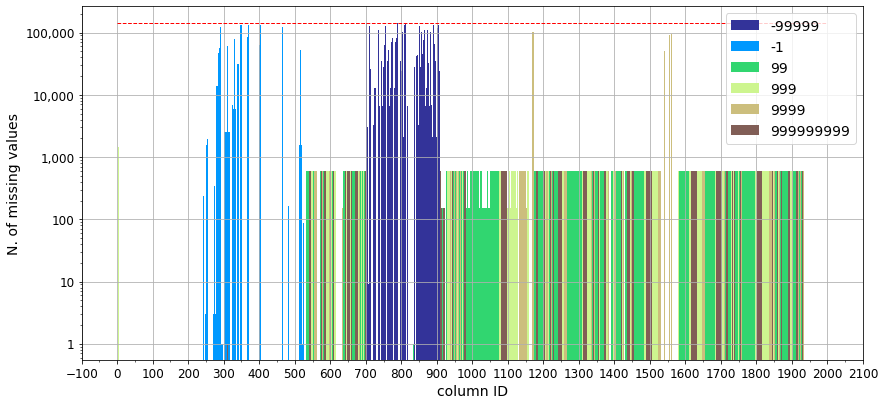

In [44]:
fig, ax = plt.subplots(figsize=(14,6.5))

co=plt.cm.terrain(np.linspace(0,0.75,6))

vals = [-99999,-1,99,999,9999,999999999]

for i, val in enumerate(vals):
    
    if val < 0:
        edges = dfi.min()
    else:
        edges = dfi.max()
        
    # columns with min/max equal to val
    cols_n = edges[edges == val].index
    
    # count vals in those columns
    var_count = (dfi[cols_n] == val).sum()
    
    #convert columns to numbers for x axis
    var_id = cols_n.str.replace('VAR_','').astype('int')
    
    ax.hist(var_id,weights=var_count,range=(0,2000),bins=2000,label= str(val),color=co[i])

ax.set_yscale('log')

ax.grid()

ax.set_xlabel("column ID",fontsize=14)
ax.set_ylabel("N. of missing values",fontsize=14)

ax.tick_params(axis="x", labelsize=12) 
ax.tick_params(axis="y", labelsize=12) 

ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend(loc='upper right',fontsize=14)
ax.hlines(dfi.shape[0],0,2000,linewidth=1,linestyle='--',color='r');

A pretty busy plot, but let's focus on main features:

1) it's clear now that most of the columns in which we didn't find any NaNs (ID > 530) contain missing values encoded with large positive numbers (99, 999, etc). These numbers seem to have the same multiplicities (a block-like structure for green/yellow/brown colors),

2) the number -99999 (dark blue) frequently appears in columns with ID = 700-900,

3) the -1 digit (light blue) is also frequent and populates columns with ID = 250-500, which as we remember, also contain NaNs. 

Generally, we have missing values all over the dataset, with some columns populated by more than one type of missing values (-1 in light blue bins where also NaNs are present). We will have to find a clever way of dealing with these later. For now, as a final check, let's find how often the numbers 99 - 999999999 appear in the columns with ID > 530:

In [45]:
for val in vals[2:]:
    
    v = (dfi == val).sum()
    print(val,':',v[v>10].value_counts().head(2).index.values)

99 : [601. 150.]
999 : [601. 150.]
9999 : [601. 150.]
999999999 : [601. 150.]


Not often. The two most freqent values are 601 and 150 entries, which is less than 0.5% of the total number of rows. There's probably another small block of empty rows in the dataset.

### 4.2 Numerical features, floats <a id='#4.2'></a>

In [46]:
dff = df_work.convert_dtypes().select_dtypes(include='float')
dpf = df_pred.convert_dtypes().select_dtypes(include='float')

dff.shape, dpf.shape

((145231, 10), (145232, 10))

There are only 10 float variables, so let's print out some more information about them:

In [47]:
dff.describe().round(5)

,VAR_0299,VAR_0300,VAR_0301,VAR_0319,VAR_0320,VAR_0321,VAR_0335,VAR_0336,VAR_0337,VAR_0370
count,144313.00000,144313.00000,144313.00000,144313.00000,144313.00000,144313.00000,144313.00000,144313.00000,144313.00000,144313.00000
mean,0.44627,0.47951,0.48448,0.40525,0.43704,0.44089,0.27663,0.30853,0.30886,-0.85966
std,0.76700,0.70453,0.80447,0.87230,0.76700,0.85909,0.75324,0.78557,0.81939,1.57305
min,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000
25%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000
50%,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000
75%,0.83000,0.96000,0.95000,0.79000,0.94000,0.92000,0.57000,0.78000,0.75000,-1.00000
max,99.00000,49.83000,99.00000,99.00000,70.49000,99.00000,99.00000,77.42000,99.00000,99.00000


In [48]:
more_info = dff.agg([lambda x: x.nunique(),lambda x: x.isna().sum()],axis=0)
more_info.index = ['N unique','N missing']
more_info

,VAR_0299,VAR_0300,VAR_0301,VAR_0319,VAR_0320,VAR_0321,VAR_0335,VAR_0336,VAR_0337,VAR_0370
N unique,579,620,619,582,619,615,588,606,620,493
N missing,918,918,918,918,918,918,918,918,918,918


Interestingly, they all have the minimum value of -1, and most of them have the maximum value of 99. Plus, they all have 918 rows contain NaNs, so we're dealing with 3 different types of missing values! Moreover, the mean value is smaller than 1 and median is at most 0, so the variables have asymmetric and very steeply falling distirbutions. 

### 4.3 Categorical  features <a id='#4.3'></a>

In [49]:
dfc = df_work.convert_dtypes().select_dtypes(include='string')
dpc = df_pred.convert_dtypes().select_dtypes(include='string')

dfc.shape,dpc.shape

((145231, 34), (145232, 34))

34 string variables, which could contain any kind of information. Let's inspect all the columns and print their content for the first 5 rows of the dataset:

In [50]:
dfc.iloc[:,0:8].dropna().head()

,VAR_0001,VAR_0005,VAR_0073,VAR_0075,VAR_0156,VAR_0157,VAR_0158,VAR_0159
ID,,,,,,,,
166,R,N,11SEP12:00:00:00,24SEP10:00:00:00,02AUG11:00:00:00,05JUL12:00:00:00,31JAN12:00:00:00,04JUN12:00:00:00
249,R,C,01OCT12:00:00:00,02NOV09:00:00:00,05MAY11:00:00:00,05JUN11:00:00:00,01MAR12:00:00:00,02FEB12:00:00:00
604,R,B,22JUN12:00:00:00,09NOV11:00:00:00,09NOV11:00:00:00,26MAY12:00:00:00,22FEB12:00:00:00,26MAR12:00:00:00
886,R,N,12JUN12:00:00:00,01APR09:00:00:00,01JAN12:00:00:00,16JUN12:00:00:00,29FEB12:00:00:00,18MAY12:00:00:00
3062,H,B,07MAR12:00:00:00,06SEP10:00:00:00,12OCT11:00:00:00,09MAR12:00:00:00,02MAR12:00:00:00,07MAR12:00:00:00


In [51]:
dfc.iloc[:,8:16].dropna().head()

,VAR_0166,VAR_0167,VAR_0168,VAR_0169,VAR_0176,VAR_0177,VAR_0178,VAR_0179
ID,,,,,,,,
79,16APR12:00:00:00,09JUN12:00:00:00,25MAY12:00:00:00,25MAY12:00:00:00,16APR12:00:00:00,09JUN12:00:00:00,25MAY12:00:00:00,25MAY12:00:00:00
249,05APR10:00:00:00,21MAY12:00:00:00,20APR11:00:00:00,13APR12:00:00:00,05APR10:00:00:00,21MAY12:00:00:00,01MAR12:00:00:00,13APR12:00:00:00
587,28MAR11:00:00:00,06APR11:00:00:00,05APR11:00:00:00,28MAR11:00:00:00,28MAR11:00:00:00,06APR11:00:00:00,05APR11:00:00:00,28MAR11:00:00:00
606,01APR11:00:00:00,14MAY12:00:00:00,13APR12:00:00:00,13APR12:00:00:00,01APR11:00:00:00,14MAY12:00:00:00,13APR12:00:00:00,13APR12:00:00:00
650,13JAN10:00:00:00,25JAN12:00:00:00,27SEP10:00:00:00,21DEC11:00:00:00,13JAN10:00:00:00,25JAN12:00:00:00,27SEP10:00:00:00,21DEC11:00:00:00


In [52]:
dfc.iloc[:,16:26].dropna().head()

,VAR_0200,VAR_0204,VAR_0214,VAR_0217,VAR_0237,VAR_0274,VAR_0283,VAR_0305,VAR_0325,VAR_0342
ID,,,,,,,,,,
15644,VISALIS,31JAN14:23:33:00,HRE-Home Phone-0621,05OCT12:02:00:00,CA,PA,S,S,S,EE
87489,BATON ROUGE,30JAN14:21:09:00,HRE-Social Security Number-1373,19APR12:02:00:00,LA,LA,H,H,P,CF
101014,DALLAS,31JAN14:18:34:00,HRE-Social Security Number-1289,16AUG12:02:00:00,TX,TX,H,H,S,UF
113977,GREENVILLE,30JAN14:23:20:00,HRE-Social Security Number-1747,24MAY12:02:00:00,SC,NY,S,S,H,EE
123414,MONTGOMERY,30JAN14:21:19:00,HRE-Social Security Number-1397,20APR12:02:00:00,AL,AL,S,S,S,FF


In [53]:
dfc.iloc[:,26:34].dropna().head()

,VAR_0352,VAR_0353,VAR_0354,VAR_0404,VAR_0466,VAR_0467,VAR_0493,VAR_1934
ID,,,,,,,,
2,O,U,O,CHIEF EXECUTIVE OFFICER,-1,-1,COMMUNITY ASSOCIATION MANAGER,IAPS
4,O,R,R,-1,I,Discharged,-1,IAPS
5,R,R,-1,-1,-1,-1,-1,IAPS
7,R,R,-1,-1,-1,-1,-1,RCC
8,R,U,O,-1,-1,-1,-1,BRANCH


Interestingly, about half of the columns contain the datetime data that were not recognized as such by pandas, probably because of the non-standard date format. Among them, only one column (VAR_0204) has the time field filled with non-zero values down to seconds, all the other columns have the time set to 00:00:00 (or to 02:00:00 for the column VAR_0217). Later we wll investigate this structure in more detail.

For now, as the datetime columns require different treatment than other data types, let's copy them to a separate dataset:

In [54]:
cols_t = [col for col in dfc.columns if dfc[col].str.contains(':00').sum()>0]

dft = dfc[cols_t]
dpt = dpc[cols_t]

dft.shape,dpt.shape

((145231, 16), (145232, 16))

and remove from the sample containing other string variables:

In [55]:
dfc = dfc.drop(cols_t,axis=1)
dpc = dpc.drop(cols_t,axis=1)

dfc.shape,dfc.shape

((145231, 18), (145231, 18))

How many missing values are there in the datetime data:

In [56]:
dft.isna().sum()

VAR_0073    101127
VAR_0075        56
VAR_0156    139361
VAR_0157    144311
VAR_0158    143142
VAR_0159    139361
VAR_0166    131001
VAR_0167    142664
VAR_0168    134506
VAR_0169    131001
VAR_0176    127699
VAR_0177    141873
VAR_0178    133158
VAR_0179    127699
VAR_0204        56
VAR_0217        56
dtype: int64

Plenty! In 13 columns NaNs are present in more than 100,000 rows, corresponding to missing fraction that varies from ~70 to 99.4%. These columns are listed among 24 of those highly populated with NaNs that were mentioned in Sec. 3.3. Only 3 columns are almost fully filled with data, they miss values in only 56 rows (0.04% of total). We will investigate this structure later.

Now back to the string data. We're left with 18 columns, let's print their content again:

In [57]:
dfc.iloc[:,0:12].dropna().head()

,VAR_0001,VAR_0005,VAR_0200,VAR_0214,VAR_0237,VAR_0274,VAR_0283,VAR_0305,VAR_0325,VAR_0342,VAR_0352,VAR_0353
ID,,,,,,,,,,,,
15644,R,B,VISALIS,HRE-Home Phone-0621,CA,PA,S,S,S,EE,U,U
87489,R,C,BATON ROUGE,HRE-Social Security Number-1373,LA,LA,H,H,P,CF,R,R
101014,R,B,DALLAS,HRE-Social Security Number-1289,TX,TX,H,H,S,UF,R,U
113977,H,C,GREENVILLE,HRE-Social Security Number-1747,SC,NY,S,S,H,EE,O,R
123414,H,C,MONTGOMERY,HRE-Social Security Number-1397,AL,AL,S,S,S,FF,U,U


In [58]:
dfc.iloc[:,12:18].dropna().head()

,VAR_0354,VAR_0404,VAR_0466,VAR_0467,VAR_0493,VAR_1934
ID,,,,,,
2,O,CHIEF EXECUTIVE OFFICER,-1,-1,COMMUNITY ASSOCIATION MANAGER,IAPS
4,R,-1,I,Discharged,-1,IAPS
5,-1,-1,-1,-1,-1,IAPS
7,-1,-1,-1,-1,-1,RCC
8,O,-1,-1,-1,-1,BRANCH


together with the corresponding number of unique values, and missing values coded with NA and with -1:

In [59]:
more_info = dfc.agg([lambda x: x.nunique(),lambda x: x.isna().sum(),lambda x: (x == '-1').sum()],axis=0)
more_info.index = ['N unique','N(nans)', 'N(-1)']
more_info.T

,N unique,N(nans),N(-1)
VAR_0001,3,0,0
VAR_0005,4,0,0
VAR_0200,12385,60,0
VAR_0214,12,145219,0
VAR_0237,45,56,0
VAR_0274,57,918,327
VAR_0283,7,918,4960
VAR_0305,8,918,2907
VAR_0325,9,918,13574
VAR_0342,50,918,30969


What can we say about the data?

1) One immediate observation is that column VAR_0214 contains 145,219 NaNs and 12 unique values. They add up to 145,231, which is exactly the number of rows in the dataset. This means that the column contains only 12 non-zero entries, and they correspond to social security number of a handfull of patients. Such column has no impact on the modeling of client response, so we will remove it from the dataset:

In [60]:
dfc = dfc.drop('VAR_0214',axis=1)
dpc = dpc.drop('VAR_0214',axis=1)

dfc.shape,dpc.shape

((145231, 17), (145232, 17))

2) column VAR_0200 has very large number of unique values (12.3k) corresponding to names of US cities, which is clearly too large to be treated as a categorical variable. To overcome this problem, we will use external information from census data and convert a city name to its population size.


3) also columns VAR_0404 and VAR_0493 contain very large number of unique values (1.8k and 600) that cannot be treated as categorical variables. They have a very large number of missing values encoded with -1, ~130k or 93% of total rows. What do they contain?:

In [61]:
dfc['VAR_0404'].unique()

<StringArray>
[            'CHIEF EXECUTIVE OFFICER',                                  '-1',
                               'CONTA',                             'CONTACT',
                           'PRESIDENT',              'RECEPTIONIST/SECRETARY',
                               'AGENT',                       'OWNER/MANAGER',
                          'REGISTRANT',                                  <NA>,
 ...
                              'TRADER',               'INTERACTIVE DEVELOPER',
 'SHOWCASE W AND  CELEB EVENT DESIGNE',           'INSURANCE/BILLING MANAGER',
                   'PROGRAM ASSISTANT',   'MEMBERSHIP AND MARKETING DIRECTOR',
             'NITSCHMANN TECHNOLOGIST',                     'GENERAL COUNSEL',
    'DEPUTY FEDERAL SECURITY DIRECTOR',                'COMPLIMENTARY MEMBER']
Length: 1824, dtype: string

In [62]:
dfc['VAR_0493'].unique()

<StringArray>
['COMMUNITY ASSOCIATION MANAGER',                            '-1',
      'LICENSED PRACTICAL NURSE',     'LICENSED VOCATIONAL NURSE',
  'EMERGENCY MEDICAL TECHNICIAN',                  'ELECTRICIANS',
      'STAFF NURSE/GENERAL DUTY',                            <NA>,
                     'COUNSELOR',              'REGISTERED NURSE',
 ...
           'INTERNS & RESIDENTS',           'REGISTERED VET TECH',
        'MEDICAL X-RAY OPERATOR',  'VETERINARY ANIMAL TECHNICIAN',
          'BACHELOR SOCIAL WORK',                'BRAKE ADJUSTER',
       'AGENCY EMPLOYEE - ARMED', 'CERTIFIED BLACKFLOW OPERATORS',
                  'ARCHITECTURE',           'RESIDENTIAL WIREMAN']
Length: 609, dtype: string

Names of customer or patient professions, which might be difficult to encode into a few categorical variables. We will give it a try in the next chapter, but it's probable that these two columns will be removed from the dataset as well.

4) All the other columns have less than 60 unique values (and most of them even less than 10) coded by a letter and a short abbreviation. They are the classic examples of categorical variables. Among them, there are 2 columns VAR_0237 and VAR_0274 that contain abbreviations of US states. As far as missing values are concerned, these columns have the fraction of empty rows that varies from 0 to as high as 84%, so in next sections we will need to investigate how this might affect the customer churn prediction.

### 5. Supporting dataset with city information<a id='5'></a>

One of the categorical variables contains about 12k entries with city names, which we said we would convert to a numerical feature with city population information. To do so, we will use a city database that is publically available at [https://simplemaps.com/data/us-cities](https://simplemaps.com/data/us-cities). It is based on the data from the U.S. Geological Survey and U.S. Census Bureau, contains information on all Census-recognized cities/towns from all 50 states. The database is very well documented and was last updated in Nov 2020, so  we hope we have up-to-date information.

Let's load the data and prepare it for further processing:

In [63]:
db = pd.read_csv("uscities.csv")

In [64]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28372 entries, 0 to 28371
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          28372 non-null  object 
 1   city_ascii    28372 non-null  object 
 2   state_id      28372 non-null  object 
 3   state_name    28372 non-null  object 
 4   county_fips   28372 non-null  int64  
 5   county_name   28372 non-null  object 
 6   lat           28372 non-null  float64
 7   lng           28372 non-null  float64
 8   population    28372 non-null  int64  
 9   density       28372 non-null  float64
 10  source        28372 non-null  object 
 11  military      28372 non-null  bool   
 12  incorporated  28372 non-null  bool   
 13  timezone      28372 non-null  object 
 14  ranking       28372 non-null  int64  
 15  zips          28371 non-null  object 
 16  id            28372 non-null  int64  
dtypes: bool(2), float64(3), int64(4), object(8)
memory usage: 3.3+ MB


In [65]:
db.head(2)

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715.0,polygon,False,True,America/New_York,1,11229 11226 11225 11224 11222 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,3276.0,polygon,False,True,America/Los_Angeles,1,90291 90293 90292 91316 91311 90037 90031 9000...,1840020491


Any missing values?:

In [66]:
db.isna().sum()

city            0
city_ascii      0
state_id        0
state_name      0
county_fips     0
county_name     0
lat             0
lng             0
population      0
density         0
source          0
military        0
incorporated    0
timezone        0
ranking         0
zips            1
id              0
dtype: int64

Yes, one row with lacking zip information, let's see what's in it:

In [67]:
db[db['zips'].isna()]

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
28168,Attu Station,Attu Station,AK,Alaska,2016,Aleutians West,52.8955,173.123,17,0.0,polygon,False,True,America/Adak,3,NaN,1840037663


A place in Alaska with a population of 17 people. Probably many healthy individuals :-) Let's remove this entry from the dataset:

In [68]:
db = db.drop(db[db['zips'].isna()].index)
db.isna().sum()

city            0
city_ascii      0
state_id        0
state_name      0
county_fips     0
county_name     0
lat             0
lng             0
population      0
density         0
source          0
military        0
incorporated    0
timezone        0
ranking         0
zips            0
id              0
dtype: int64

The data provides lot of useful information, including population size, population density, and also zip codes. What's the difference between the *city* and *city_ascii* columns? Let's print out a few of them that are different:

In [69]:
db[['city','city_ascii']][db.city != db.city_ascii].head()

,city,city_ascii
270,Bayamón,Bayamon
786,Mayagüez,Mayaguez
1727,Cañon City,Canon City
1853,Española,Espanola
1927,Cataño,Catano


Ah! Non-English characters in the *city* column are converted to English letters. We will use the *city_ascii* variable then.

Let's select a subset of columns that might be relevant to us and write it out to a reduced dataset for later use:

In [70]:
db_reduced = db[['city_ascii','state_id','population','density','zips','county_fips']]
db_reduced.tail(2)

,city_ascii,state_id,population,density,zips,county_fips
28370,Roswell,SD,2,1.0,57349,46097
28371,Monowi,NE,1,1.0,68746,31015


In [71]:
db_reduced.to_csv('data/cities_reduced.csv')

### 6. Summary<a id='6'></a>

All right, it's time to save our data for next steps of the analysis:

In [72]:
y.to_csv('data/work_target.csv')

dfi.to_csv('data/work_integers.csv')
dff.to_csv('data/work_floats.csv')
dfc.to_csv('data/work_strings.csv')
dft.to_csv('data/work_datetimes.csv')

dpi.to_csv('data/pred_integers.csv')
dpf.to_csv('data/pred_floats.csv')
dpc.to_csv('data/pred_strings.csv')
dpt.to_csv('data/pred_datetimes.csv')

In [73]:
#! date
#! ls -lrth data/ | grep csv